# Homework 2: Autocorrelation

Stine Fohrmann

![](plots/autocorrelation.png)


The autocorrelation of heat wave days (HWDs) is mostly above the upper 95% confidence band, but at least equal to it. Therefore, there is significant positive correlation between the number of HWDs, and the signal is not just white noise.

The first statistically significant correlation is at a lag of 3 months and continues until 9 months. On one hand, this suggests that the chosen index is predictable with a lead time of 3 to 9 months. On the other hand, the autocorrelation is still relatively low, so forecast skill might be limited.

Additionally, there is a clear annual cycle repeating every 12 months, which suggests that there is a seasonal component. Detrending the signal would probably help to get a better picture of the autocorrelation without the seasonality.

The peaks of the annual cycle are at a lag of 6 months and every 12 months after that. The peak autocorrelation values are between 0.15 and 0.25, so the seasonal signal seems to be relatively weak.
The peaks of the autocorrelation also seem to increase slightly with increasing lag, which could suggest that there is some long-range memory in the system. It might also just be a result of the seasonal pattern, so again, detrending should probably be done in the future.

# Code

In [2]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import pandas as pd
from datetime import datetime
import scipy.stats as stats
from random import gauss, seed

In [3]:
# Read data from file
filepath = '~/code/predictions/data/ERA5_T2m_1940-2025.nc'
data = xr.open_dataset(filepath)

In [4]:
# Define time frame for reference climatology
start_date = '1940-01-01'   # inclusive
end_date   = '1969-12-31'   # inclusive

# Define area
lat_min, lat_max = 58, 63    # north‑south limits
lon_min, lon_max = 9, 13    # west‑east limits

# Select data subset for computing reference climatology (and convert to °C)
normal_subset = data.sel(
    time=slice(start_date, end_date),
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
    ) - 273.15

# Compute grid average temperature on each day
# (spatial average temperature of the grid on each individual day between 1940 and 1969)
daily_means = normal_subset.mean(dim=('lat', 'lon'))

# Compute average temperature for each day of the year
# (temporal average temperature, i.e. what to expect for Jan 03 each year)
climatology = daily_means.groupby('time.dayofyear').mean('time')
# daily_means
climatology

<xarray.Dataset> Size: 4kB
Dimensions:    (dayofyear: 366)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    var167     (dayofyear) float32 1kB -7.382 -6.854 -7.21 ... -6.387 -5.488

In [5]:
# Functions
def month_range(start_year: int, end_year: int):
    # Yield (year, month) tuples from Jan start_year to Dec end_year inclusive.
    for yr in range(start_year, end_year + 1):
        for mo in range(1, 13):
            yield yr, mo

def iso_to_dayofyear(ts: str):
    dt = datetime.fromisoformat(ts)
    doy = dt.timetuple().tm_yday
    return doy

# print(iso_to_dayofyear('2001-02-29'))

In [6]:
heat_wave_days = []
months = []

for y, m in month_range(1940,2024):
    months.append(f'{y}-{m}')

    # Select all data from selected year and area
    subset = data.sel(
        time=f'{y}-{m}',
        lat=slice(lat_min, lat_max),
        lon=slice(lon_min, lon_max),
        )-273.15    # convert to °C
    
    # subset = data.sel(
    #     time=f'{y}-{m}',
    #     method='nearest').sel(
    #     lat=slice(lat_min, lat_max),
    #     lon=slice(lon_min, lon_max)
    #     )-273.15    # convert to °C

    # Compute average temp in grid for each day of the selected time frame
    daily_grid_mean = subset.mean(dim=('lat', 'lon'))

    # Convert specific date into 'dayofyear' (necessary for anomaly calculation)
    daily_grid_mean_toy = daily_grid_mean.copy().groupby('time.dayofyear').mean('time')

    # Compute diffence between daily grid mean temp and expected temp
    difference = daily_grid_mean_toy-climatology

    # Select anomalies greater than +5°C
    above_thr = difference >= 5
    num_anomalies = above_thr['var167'].sum().item()
    heat_wave_days.append(num_anomalies)

# months, heat_wave_days
# subset
# num_anomalies
# heat_wave_days

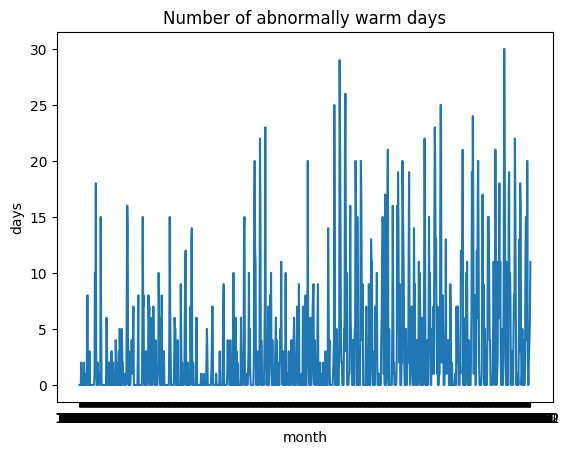

In [7]:
# plot time series with monthly heat wave days
plt.plot(months, heat_wave_days, '-')
plt.title('Number of abnormally warm days')
plt.ylabel(r'days')
plt.xlabel(r'month')
# plt.savefig('plots/homework1-timeseries.png')
plt.show()

In [8]:
# Create time series for plotting and for regression
time = np.arange(0, len(months), 1)
time

array([   0,    1,    2, ..., 1017, 1018, 1019], shape=(1020,))

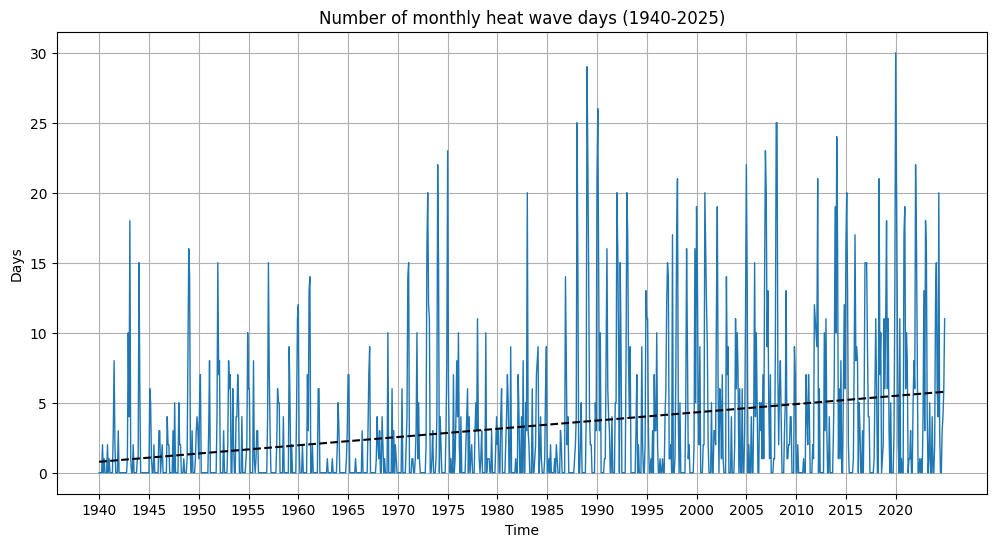

In [9]:
# Plot data
plt.figure(figsize=(12,6))

# plot time series
plt.plot(time, heat_wave_days, lw=1)

# calculate best-fit line
a = np.polyfit(time, heat_wave_days, 1)
hwd_polyval = np.polyval(a, time)

# plot best-fit line
plt.plot(time, hwd_polyval, 'k', ls='--')

plt.xticks(np.arange(0,len(time),12*5),np.arange(1940,2025,5))
plt.grid()

plt.title("Number of monthly heat wave days (1940-2025)")
plt.xlabel("Time")
plt.ylabel("Days")

plt.show()

In [10]:
# # linear regression
# slope, intercept, r_value, p_value, std_err = stats.linregress(time,heat_wave_days)
# # slope:        gradient of fitted line (change in heat wave days / month)
# # intercept:    value of the line when time=0
# # r_value:      correlation coefficient (how well the line explains the data)
# # p_value:      probability that a slope of 0 would produce the data
# # std_err:      standard error of estimated slope

# # 95% 2-sided confidence interval
# crit = stats.t.ppf(0.975,len(time)-2)
# confidence_interval = crit*std_err
# print("The value of the slope is", np.round(slope*12,3), "+/-", np.round(confidence_interval*12,3), "days/year")

## Autocorrelation

In [11]:
# Compute autocorrelation
hwd_autocorr = np.correlate(heat_wave_days, heat_wave_days, 'same')
hwd_autocorr_norm = hwd_autocorr / hwd_autocorr[hwd_autocorr.size // 2:][0]
hwd_autocorr_norm

array([0.05941152, 0.06953558, 0.07284191, ..., 0.10318844, 0.07284191,
       0.06953558], shape=(1020,))

In [12]:
# White noise
seed(1)
wn_series = [gauss(0.0, 1.0) for i in range(len(heat_wave_days))]

wn_autocorr = np.correlate(wn_series, wn_series, 'same')
wn_autocorr_norm = wn_autocorr / wn_autocorr[wn_autocorr.size // 2:][0]
# wn_autocorr_norm

In [13]:
alpha = 0.05
N = len(heat_wave_days)
z = stats.norm.ppf(1 - alpha/2)
conf_limit = z / np.sqrt(N)

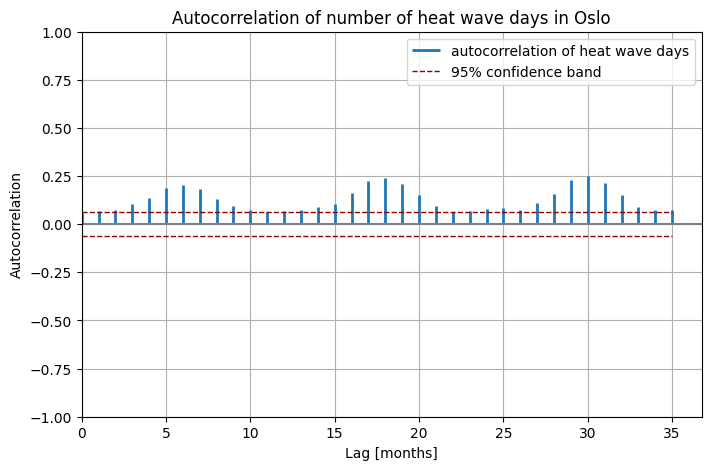

In [14]:
# Plot autocorrelation

fig, ax = plt.subplots(figsize=(8,5))

# Select lags
lags = np.arange(len(hwd_autocorr_norm[:36]))

# Plot autocorrelation as vertical lines
ax.vlines(lags, 0, hwd_autocorr_norm[:36], lw=2, label='autocorrelation of heat wave days')
# ax.vlines(lags, 0, wn_autocorr_norm[:36], color='k', label='autocorrelation of white noise')

ax.hlines([conf_limit, -conf_limit], xmin=lags[0], xmax=lags[-1],
          colors='darkred', linestyles='dashed', linewidth=1, label='95% confidence band')

# Plot x-axis
plt.axhline(0, c='grey')

plt.xlim(0)
plt.ylim(-1,1)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag [months]')
plt.title('Autocorrelation of number of heat wave days in Oslo')
plt.legend()
plt.grid()
plt.savefig('plots/autocorrelation.png')
plt.show()